In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import statsmodels.api as sm
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# Basic Filters

In [2]:
def basic_filters(data, trt1m=False,curcd=False):
    data = data[(~data['sic'].between(6000,6999))& #FINANCIALS
                #(data['sic']!=2834)& #PHARMA
                (data['fic']=='USA') &
                (data['exchg'].between(11,19))]
    if trt1m:
        data = data[(~data['trt1m'].isnull()) &
                    (~data['trt1m'].isna()) &
                    (~data['trt1m'].astype(str).str.contains('[a-zA-Z]')) &
                    (data['trt1m']>-100)&
                    (data['trt1m']<1000)]
    if curcd:
        data = data[(data['curcd']=='USD')]
    return data
    

# Fundamentals data

In [4]:
fundamentals = pd.read_csv('fundamentals_annual.csv')
# Get year data
fundamentals['datadate'] = pd.to_datetime(fundamentals['datadate'], format='%Y-%m-%d')
fundamentals['fyear'] = fundamentals['datadate'].dt.year
fundamentals.sort_values(by=['LPERMNO','datadate'],inplace=True)
# Apply basic filters
fundamentals_filtered = basic_filters(fundamentals, trt1m=False,curcd=True)
#Create market cap | fill missings with 0 | filter market caps greater than 10 to avoid outliers
fundamentals_filtered['market_cap'] = fundamentals_filtered['csho']*fundamentals_filtered['prcc_f']
fundamentals_filtered['market_cap'] = fundamentals_filtered['market_cap'].fillna(0)
#fundamentals_filtered = fundamentals_filtered[fundamentals_filtered['market_cap']>10]
#Drop duplicates 
fundamentals_filtered.sort_values(by=['LPERMNO','datadate'],ascending=False, inplace=True) 
fundamentals_filtered.drop_duplicates(subset=['LPERMNO','fyear'],inplace=True)
print("Len of original df:",len(fundamentals),"\nLen of filtered df:",len(fundamentals_filtered),"\nObs removed:",len(fundamentals)-len(fundamentals_filtered),"(",(len(fundamentals)-len(fundamentals_filtered))/len(fundamentals),")")
#Drop 2024
fundamentals_filtered = fundamentals_filtered[fundamentals_filtered['fyear']<2024]
fundamentals_filtered.head()


Len of original df: 51539 
Len of filtered df: 29184 
Obs removed: 22355 ( 0.4337491996352277 )


,GVKEY,LPERMNO,LINKDT,datadate,fyear,indfmt,consol,popsrc,datafmt,tic,...,auopic,ceoso,cfoso,city,conml,gind,sic,state,ipodate,market_cap
47727,184996,93436,2010-06-29,2023-12-31,2023,INDL,C,D,STD,TSLA,...,1.0,Y,Y,Austin,Tesla Inc,251020.0,3711,TX,2010-06-29,791408.80
47726,184996,93436,2010-06-29,2022-12-31,2022,INDL,C,D,STD,TSLA,...,1.0,Y,Y,Austin,Tesla Inc,251020.0,3711,TX,2010-06-29,389741.52
47725,184996,93436,2010-06-29,2021-12-31,2021,INDL,C,D,STD,TSLA,...,1.0,Y,Y,Austin,Tesla Inc,251020.0,3711,TX,2010-06-29,1091653.74
47724,184996,93436,2010-06-29,2020-12-31,2020,INDL,C,D,STD,TSLA,...,1.0,Y,Y,Austin,Tesla Inc,251020.0,3711,TX,2010-06-29,677443.20
47723,184996,93436,2010-06-29,2019-12-31,2019,INDL,C,D,STD,TSLA,...,1.0,Y,Y,Austin,Tesla Inc,251020.0,3711,TX,2010-06-29,75717.73


In [5]:
fundamentals_filtered.groupby(['fyear'])['LPERMNO'].count()

fyear
2014    2784
2015    3095
2016    3015
2017    2989
2018    2987
2019    2966
2020    3061
2021    3428
2022    3380
2023    1476
Name: LPERMNO, dtype: int64

In [6]:
#fundamentals_small = fundamentals_filtered[fundamentals_filtered['revt']<=5.8]
def getSmaller1k(data):
    return data.sort_values(by='revt').head(1000)

fundamentals_small = fundamentals_filtered.groupby('fyear').apply(getSmaller1k)
fundamentals_small = fundamentals_small.reset_index(drop=True)
fundamentals_small.groupby(['fyear'])['LPERMNO'].count()


fyear
2014    1000
2015    1000
2016    1000
2017    1000
2018    1000
2019    1000
2020    1000
2021    1000
2022    1000
2023    1000
Name: LPERMNO, dtype: int64

In [7]:
fundamentals_small['revt'].quantile([0,0.01,0.05,0.1,0.15,0.2,0.25,0.4,0.5,0.6,0.7,0.8,0.9,0.95,0.99,1])
                                    

0.00   -1964.99900
0.01       0.00000
0.05       0.00000
0.10       0.00000
0.15       0.00000
0.20       0.03100
0.25       0.53750
0.40       8.27840
0.50      18.52900
0.60      31.80000
0.70      50.28840
0.80      86.26760
0.90     143.02430
0.95     822.64160
0.99    3315.46494
1.00    4320.57700
Name: revt, dtype: float64

In [8]:
fundamentals_small = fundamentals_small[(fundamentals_small['revt']>fundamentals_small['revt'].quantile(0.01))&
                                        (fundamentals_small['revt']<=fundamentals_small['revt'].quantile(0.9))]

In [9]:
fundamentals_small.groupby(['fyear'])['LPERMNO'].count()

fyear
2014    776
2015    835
2016    823
2017    804
2018    779
2019    757
2020    733
2021    678
2022    680
2023    183
Name: LPERMNO, dtype: int64

In [10]:
fundamentals_small[['fyear','tic','conm','conml','sic']].to_csv('small_companies.csv',index=False)

In [11]:
fundamentals_small.to_csv('small_companies_variables.csv')

# Reading Files

In [12]:
# Universe and variables
fundamentals = pd.read_csv('small_companies_variables.csv',index_col=0)
print(len(fundamentals.columns))
fundamentals.head()


914


,GVKEY,LPERMNO,LINKDT,datadate,fyear,indfmt,consol,popsrc,datafmt,tic,...,auopic,ceoso,cfoso,city,conml,gind,sic,state,ipodate,market_cap
127,18566,91078,2014-08-21,2014-12-31,2014,INDL,C,D,STD,IMNPQ,...,0.0,Y,Y,Fort Lee,Immune Pharmaceuticals Inc,352010.0,2836,NJ,NaN,45.312750
128,21126,90968,2014-07-16,2014-12-31,2014,INDL,C,D,STD,EPRSQ,...,0.0,Y,Y,Boston,EPIRUS Biopharmaceuticals Inc,352010.0,2836,MA,NaN,73.262070
129,157080,12760,2011-05-09,2014-12-31,2014,INDL,C,D,STD,RVM,...,0.0,Y,Y,Spokane Valley,Revett Mining Co Inc,151040.0,1000,WA,2005-02-15,28.933156
130,18738,18148,2013-09-30,2014-12-31,2014,INDL,C,D,STD,DOMH,...,0.0,Y,Y,New York,Dominari Holdings Inc,352010.0,2836,NY,NaN,30.897720
131,176229,92252,2007-08-27,2014-12-31,2014,INDL,C,D,STD,SNCA,...,0.0,Y,Y,Germantown,Seneca Biopharma Inc,352010.0,2836,MD,NaN,238.788800


In [13]:
#PDs
mapped_pds = pd.read_csv('mapped_pds.csv',index_col=0)
mapped_pds = mapped_pds[mapped_pds['Year']>=2016]
mapped_pds = mapped_pds[['Year', 'Company Name', 'Ticker', 'pd_score']]
mapped_pds['Year_1'] = mapped_pds['Year']-1
mapped_pds.rename(columns={'Year_1':'fyear','Ticker':'tic'},inplace=True)
mapped_pds.head()

FileNotFoundError: [Errno 2] No such file or directory: 'mapped_pds.csv'

In [ ]:
# states
states_regions = pd.read_csv('regions_divisions.csv')
states_regions.head()

,State,State Code,Region,Division
0,Alaska,AK,West,Pacific
1,Alabama,AL,South,East South Central
2,Arkansas,AR,South,West South Central
3,Arizona,AZ,West,Mountain
4,California,CA,West,Pacific


In [ ]:
mapped_pds['pd_score'] = np.where(mapped_pds['pd_score'].isin(['NaN','#N/A Invalid Security']),np.nan,mapped_pds['pd_score'])
mapped_pds['pd_score'] = mapped_pds['pd_score'].astype(float)

In [ ]:
print(len(fundamentals))
fundamentals = fundamentals.merge(mapped_pds, on=['fyear','tic'], how='left')
print(len(fundamentals))
fundamentals = fundamentals.merge(states_regions, left_on='state' ,right_on='State Code', how='left')
print(len(fundamentals))
fundamentals.head()

7048
7048
7048


,GVKEY,LPERMNO,LINKDT,datadate,fyear,indfmt,consol,popsrc,datafmt,tic,...,state,ipodate,market_cap,Year,Company Name,pd_score,State,State Code,Region,Division
0,18566,91078,2014-08-21,2014-12-31,2014,INDL,C,D,STD,IMNPQ,...,NJ,NaN,45.312750,NaN,NaN,NaN,New Jersey,NJ,Northeast,Middle Atlantic
1,21126,90968,2014-07-16,2014-12-31,2014,INDL,C,D,STD,EPRSQ,...,MA,NaN,73.262070,NaN,NaN,NaN,Massachusetts,MA,Northeast,New England
2,157080,12760,2011-05-09,2014-12-31,2014,INDL,C,D,STD,RVM,...,WA,2005-02-15,28.933156,NaN,NaN,NaN,Washington,WA,West,Pacific
3,18738,18148,2013-09-30,2014-12-31,2014,INDL,C,D,STD,DOMH,...,NY,NaN,30.897720,NaN,NaN,NaN,New York,NY,Northeast,Middle Atlantic
4,176229,92252,2007-08-27,2014-12-31,2014,INDL,C,D,STD,SNCA,...,MD,NaN,238.788800,NaN,NaN,NaN,Maryland,MD,South,South Atlantic


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


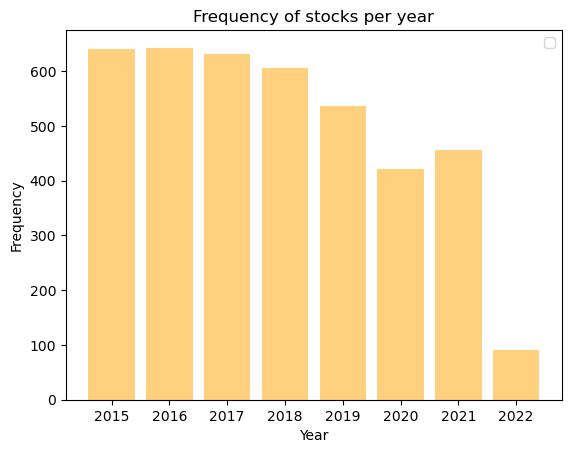

In [ ]:
tmp = fundamentals[(fundamentals['fyear'].between(2015,2022))&(~fundamentals['pd_score'].isnull())].groupby(['fyear'])['LPERMNO'].count()

fyear_values = tmp.index
counts = tmp.values

plt.bar(fyear_values, counts, color='orange', alpha=0.5)

# Add labels, title, and legend
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.title('Frequency of stocks per year')
plt.xticks(fyear_values)  # Set x-axis labels
plt.legend()

In [ ]:
fundamentals.groupby('Region')['LPERMNO'].count()

Region
Midwest       616
Northeast    2107
South        1716
West         2403
Name: LPERMNO, dtype: int64

In [ ]:
fundamentals.groupby('Division')['LPERMNO'].count()

Division
East North Central     316
East South Central      77
Middle Atlantic       1252
Mountain               589
New England            855
Pacific               1814
South Atlantic         945
West North Central     300
West South Central     694
Name: LPERMNO, dtype: int64

In [14]:
fundamentals = fundamentals[(fundamentals['fyear']>2014)&(fundamentals['fyear']<2023)&(~fundamentals['pd_score'].isnull())]
fundamentals.groupby('fyear')['pd_score'].count()

KeyError: 'pd_score'

In [ ]:
fundamentals['sic1'] = fundamentals['sic'].astype(str).str[:1]
fundamentals['gind2'] = fundamentals['gind'].astype(str).str[:2]
fundamentals['default'] = np.where(fundamentals['pd_score']>=0.07,1,0)

In [ ]:
fundamentals.to_csv('credit_risk_master_table.csv')


# Correlations analysis

## Categoricals

In [11]:
categoricals = []
for i in fundamentals.columns:
    if fundamentals[i].dtype=='object':
        categoricals = categoricals + [i]
categoricals

['LINKDT',
 'datadate',
 'indfmt',
 'consol',
 'popsrc',
 'datafmt',
 'tic',
 'conm',
 'curcd',
 'costat',
 'fic',
 'ceoso',
 'cfoso',
 'city',
 'conml',
 'state',
 'ipodate',
 'Company Name',
 'State',
 'State Code',
 'Region',
 'Division']

In [ ]:
'city', 'state','sic'  | 'tic','conm','conml'

In [12]:
fundamentals[categoricals].head()

,LINKDT,datadate,indfmt,consol,popsrc,datafmt,tic,conm,curcd,costat,...,cfoso,city,conml,state,ipodate,Company Name,State,State Code,Region,Division
777,2007-08-27,2015-12-31,INDL,C,D,STD,SNCA,SENECA BIOPHARMA INC,USD,I,...,Y,Germantown,Seneca Biopharma Inc,MD,NaN,SENECA BIOPHARMA INC,Maryland,MD,South,South Atlantic
778,1993-12-01,2015-12-31,INDL,C,D,STD,PRKR,PARKERVISION INC,USD,A,...,Y,Jacksonville,ParkerVision Inc,FL,1993-11-30,PARKERVISION INC,Florida,FL,South,South Atlantic
782,2013-09-30,2015-12-31,INDL,C,D,STD,DOMH,DOMINARI HOLDINGS INC,USD,A,...,Y,New York,Dominari Holdings Inc,NY,NaN,DOMINARI HOLDINGS INC,New York,NY,Northeast,Middle Atlantic
783,2014-02-11,2015-12-31,INDL,C,D,STD,PHIO,PHIO PHARMACEUTICALS CORP,USD,A,...,Y,Marlborough,Phio Pharmaceuticals Corp,MA,NaN,PHIO PHARMACEUTICALS CORP,Massachusetts,MA,Northeast,New England
786,2012-02-16,2015-12-31,INDL,C,D,STD,NUWE,NUWELLIS INC,USD,A,...,Y,Eden Prairie,Nuwellis Inc,MN,NaN,NUWELLIS INC,Minnesota,MN,Midwest,West North Central


In [13]:
fundamentals['sic'].astype(str).str[:1].unique()

array(['2', '3', '7', '4', '1', '8', '5', '9'], dtype=object)

In [14]:
fundamentals['gind'].astype(str).str[:2].unique()

array(['35', '45', '20', '30', '55', '10', '15', '50', '25', '40', '60'],
      dtype=object)

In [15]:
for j in categoricals:
    print(j,len(fundamentals[j].unique()))

LINKDT 1008
datadate 95
indfmt 1
consol 1
popsrc 1
datafmt 1
tic 1196
conm 1196
curcd 1
costat 2
fic 1
ceoso 3
cfoso 3
city 485
conml 1196
state 53
ipodate 630
Company Name 1196
State 49
State Code 49
Region 5
Division 10


## Continuous

In [16]:
correlations = fundamentals.corr()[['pd_score']]
correlations

,pd_score
GVKEY,0.105004
LPERMNO,-0.034349
fyear,-0.027611
acchg,NaN
acco,NaN
...,...
gind,-0.061350
sic,0.035857
market_cap,-0.105332
Year,-0.027611


In [17]:
correlations = correlations.sort_values('pd_score')
correlations['n'] = fundamentals[correlations.index].count()
correlations

,pd_score,n
spce,-0.989812,3
spceeps,-0.896989,3
spced,-0.896989,3
uspi,-0.526601,32
ugi,-0.488478,32
...,...,...
xuwnli,NaN,0
xuwoi,NaN,0
xuwrei,NaN,0
xuwti,NaN,0


In [18]:
continuos = []
for i in fundamentals.columns:
    if i not in categoricals and i!='pd_score':
        continuos = continuos+[i]
len(continuos)

898

In [15]:
correlations.to_csv('correlations.csv')

In [19]:
len(fundamentals)

4025

In [20]:
fundamentals['pd_score'].quantile([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])

0.0    0.000000
0.1    0.000039
0.2    0.000231
0.3    0.000702
0.4    0.001729
0.5    0.003528
0.6    0.007520
0.7    0.016248
0.8    0.032420
0.9    0.073607
1.0    0.505521
Name: pd_score, dtype: float64

In [21]:
fundamentals2 = fundamentals.sort_values('pd_score')
vars = []
for i in continuos:
    if i not in ['pd_score','GVKEY','LPERMNO','fyear','Year','sic']:
        fundamentals2[i] = np.where(fundamentals2[i].isnull(),0,fundamentals2[i])
        vars = vars +[i]
    

In [22]:
## Tree for bivariate
from sklearn.tree import DecisionTreeClassifier
fundamentals2['default'] = np.where(fundamentals2['pd_score']>=0.07,1,0)

X_train = fundamentals2[vars]
y_train = fundamentals2['default']

clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)



DecisionTreeClassifier(random_state=42)

In [23]:
importances = pd.DataFrame()
importances['vars'] =clf.feature_names_in_
importances['importance'] = clf.feature_importances_
importances['perc_imp'] = importances['importance']/importances['importance'].sum()
importances.sort_values('perc_imp', ascending=False, inplace=True)
importances.head()

,vars,importance,perc_imp
92,ceqt,0.091699,0.091699
892,market_cap,0.091490,0.091490
886,prcc_f,0.053051,0.053051
850,xint,0.046571,0.046571
341,ib,0.026345,0.026345


In [24]:
importances.to_csv('importances_tree_bivariate.csv')

# Multivariate

In [2]:
fundamentals = pd.read_csv('credit_risk_master_table.csv',index_col=0).reset_index(drop=True)
print(len(fundamentals))
fundamentals.head()

4025


,GVKEY,LPERMNO,LINKDT,datadate,fyear,indfmt,consol,popsrc,datafmt,tic,...,Year,Company Name,pd_score,State,State Code,Region,Division,sic1,gind2,default
0,176229,92252,2007-08-27,2015-12-31,2015,INDL,C,D,STD,SNCA,...,2016.0,SENECA BIOPHARMA INC,0.024809,Maryland,MD,South,South Atlantic,2,35,0
1,29332,80019,1993-12-01,2015-12-31,2015,INDL,C,D,STD,PRKR,...,2016.0,PARKERVISION INC,0.024382,Florida,FL,South,South Atlantic,3,45,0
2,18738,18148,2013-09-30,2015-12-31,2015,INDL,C,D,STD,DOMH,...,2016.0,DOMINARI HOLDINGS INC,0.080101,New York,NY,Northeast,Middle Atlantic,2,35,1
3,171187,14468,2014-02-11,2015-12-31,2015,INDL,C,D,STD,PHIO,...,2016.0,PHIO PHARMACEUTICALS CORP,0.006181,Massachusetts,MA,Northeast,New England,2,35,0
4,271987,13279,2012-02-16,2015-12-31,2015,INDL,C,D,STD,NUWE,...,2016.0,NUWELLIS INC,0.068560,Minnesota,MN,Midwest,West North Central,3,35,0


In [3]:
bivariate_vars = pd.read_csv('bivariate_vars.csv')
bivariate_vars.head()


,variables,data_correlations,data_tree,data_pca,data_professor,Description
0,dltis,1,0,0,0,Long-Term Debt Issuance
1,dm,1,0,0,0,Debt Mortgages & Other Secured
2,capxv,1,1,0,0,"Capital Expend Property, Plant and Equipment S..."
3,capx,1,0,0,0,Capital Expenditures
4,dd5,1,0,0,0,Debt Due in 5th Year


In [4]:
categoricals = ['sic1', 'gind2', 'Region']

for i in categoricals:
    cat = fundamentals[[i, 'pd_score']].groupby(i)['pd_score'].mean().reset_index().rename(columns={'pd_score': i+'_st'})
    fundamentals = fundamentals.merge(cat,on=i,how='left')
    
fundamentals.head() 



,GVKEY,LPERMNO,LINKDT,datadate,fyear,indfmt,consol,popsrc,datafmt,tic,...,State,State Code,Region,Division,sic1,gind2,default,sic1_st,gind2_st,Region_st
0,176229,92252,2007-08-27,2015-12-31,2015,INDL,C,D,STD,SNCA,...,Maryland,MD,South,South Atlantic,2,35,0,0.021497,0.024204,0.028697
1,29332,80019,1993-12-01,2015-12-31,2015,INDL,C,D,STD,PRKR,...,Florida,FL,South,South Atlantic,3,45,0,0.023287,0.019803,0.028697
2,18738,18148,2013-09-30,2015-12-31,2015,INDL,C,D,STD,DOMH,...,New York,NY,Northeast,Middle Atlantic,2,35,1,0.021497,0.024204,0.021497
3,171187,14468,2014-02-11,2015-12-31,2015,INDL,C,D,STD,PHIO,...,Massachusetts,MA,Northeast,New England,2,35,0,0.021497,0.024204,0.021497
4,271987,13279,2012-02-16,2015-12-31,2015,INDL,C,D,STD,NUWE,...,Minnesota,MN,Midwest,West North Central,3,35,0,0.023287,0.024204,0.020772


In [5]:
vars_finales = fundamentals[bivariate_vars['variables'].values.tolist() + ['sic1_st','gind2_st','Region_st','pd_score']]
vars_finales.head()


,dltis,dm,capxv,capx,dd5,dxd5,lcoxdr,dd1,np,dn,...,ppegt,invt,lt,sic1,gind2,Region,sic1_st,gind2_st,Region_st,pd_score
0,0.0,3.392,0.176,0.176,0.0,0.0,0.424,4.635,0.0,0.0,...,0.972,0.000,10.081,2,35,South,0.021497,0.024204,0.028697,0.024809
1,0.0,0.000,0.051,0.051,0.0,0.0,0.074,0.054,0.0,0.0,...,9.792,0.161,4.090,3,45,South,0.023287,0.019803,0.028697,0.024382
2,0.0,0.000,0.002,0.002,0.0,0.0,3.782,0.000,0.0,0.0,...,0.338,0.000,4.944,2,35,Northeast,0.021497,0.024204,0.021497,0.080101
3,0.0,0.000,0.057,0.057,0.0,0.0,0.000,0.000,0.0,0.0,...,0.941,0.000,2.269,2,35,Northeast,0.021497,0.024204,0.021497,0.006181
4,8.0,3.941,0.199,0.199,0.0,0.0,1.368,3.858,0.0,0.0,...,1.645,0.000,12.399,3,35,Midwest,0.023287,0.024204,0.020772,0.068560


In [51]:
multivariate = vars_finales.corr()
multivariate['n'] = fundamentals[multivariate.columns].count()
multivariate.to_csv('multivariate.csv')
multivariate.head()

,dltis,dm,capxv,capx,dd5,dxd5,lcoxdr,dd1,np,dn,...,ppegt,invt,lt,sic1,gind2,sic1_st,gind2_st,Region_st,pd_score,n
dltis,1.000000,0.457112,0.413791,0.413791,0.543333,0.552167,0.226860,0.115320,0.122545,0.244347,...,0.262664,0.077224,0.552663,-0.047934,-0.075721,0.027759,0.097282,0.047219,0.051484,3978
dm,0.457112,1.000000,0.460450,0.460450,0.312302,0.309846,0.217739,0.106041,-0.001505,0.535859,...,0.564927,0.014979,0.750962,-0.030295,-0.015240,0.059232,0.138470,0.080501,0.053973,3918
capxv,0.413791,0.460450,1.000000,1.000000,0.358429,0.357236,0.314951,0.026695,0.041346,0.419053,...,0.514790,0.034366,0.445841,-0.064128,-0.144362,0.148417,0.113914,0.085793,0.055523,4021
capx,0.413791,0.460450,1.000000,1.000000,0.358429,0.357236,0.314951,0.026695,0.041346,0.419053,...,0.514790,0.034366,0.445841,-0.064128,-0.144362,0.148417,0.113914,0.085793,0.055523,4021
dd5,0.543333,0.312302,0.358429,0.358429,1.000000,0.999895,0.219417,0.027466,-0.005793,0.312395,...,0.219335,0.023808,0.412244,-0.036464,-0.020078,0.016407,0.029824,0.054238,0.058726,3512


In [8]:
final_var = pd.read_csv('final_variables.csv')
final_var.head()

,wharton,Description
0,np,Notes Payable Short-Term Borrowings
1,ivstch,Short-Term Investments Change
2,dlc,Debt in Current Liabilities - Total
3,dt,Total Debt Including Current
4,auop,Auditor Opinion


In [14]:
finals_var = ['LPERMNO','fyear','sic','gind','Region','conml','conm']+final_var['wharton'].to_list()+['pd_score']
fundamentals[finals_var].to_csv('pre_final_master_table.csv')


# Models

In [2]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import statsmodels.api as sm
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from imblearn import over_sampling

### Reading files

In [3]:
master = pd.read_csv('credit_risk_master_table.csv',index_col=0)
master.head()

,GVKEY,LPERMNO,LINKDT,datadate,fyear,indfmt,consol,popsrc,datafmt,tic,...,Year,Company Name,pd_score,State,State Code,Region,Division,sic1,gind2,default
777,176229,92252,2007-08-27,2015-12-31,2015,INDL,C,D,STD,SNCA,...,2016.0,SENECA BIOPHARMA INC,0.024809,Maryland,MD,South,South Atlantic,2,35,0
778,29332,80019,1993-12-01,2015-12-31,2015,INDL,C,D,STD,PRKR,...,2016.0,PARKERVISION INC,0.024382,Florida,FL,South,South Atlantic,3,45,0
782,18738,18148,2013-09-30,2015-12-31,2015,INDL,C,D,STD,DOMH,...,2016.0,DOMINARI HOLDINGS INC,0.080101,New York,NY,Northeast,Middle Atlantic,2,35,1
783,171187,14468,2014-02-11,2015-12-31,2015,INDL,C,D,STD,PHIO,...,2016.0,PHIO PHARMACEUTICALS CORP,0.006181,Massachusetts,MA,Northeast,New England,2,35,0
786,271987,13279,2012-02-16,2015-12-31,2015,INDL,C,D,STD,NUWE,...,2016.0,NUWELLIS INC,0.068560,Minnesota,MN,Midwest,West North Central,3,35,0


In [4]:
final_vars = pd.read_csv('final_final_variables.csv')
final_vars.head()

,wharton,Description,var,levels,Decision,corr pd_score,Fill Rate,corr,tree,pca,prof
0,np,Notes Payable Short-Term Borrowings,np,NaN,No,7.40%,100%,1.0,1.0,0.0,0.0
1,ivstch,Short-Term Investments Change,ivstch,Never,No,8.55%,81%,1.0,0.0,0.0,0.0
2,dlc,Debt in Current Liabilities - Total,dlc,Never,No,9.13%,100%,1.0,1.0,0.0,0.0
3,dt,Total Debt Including Current,dt,NaN,maybe,10.21%,99%,1.0,1.0,0.0,0.0
4,auop,Auditor Opinion,auop,Never,No,23.09%,100%,1.0,1.0,0.0,0.0


In [5]:
keys = ['LPERMNO','fyear','conml','conm','sic']
vars_yes = list(final_vars[final_vars['Decision']=='si']['var'].values)
vars_yes.remove('sic1_st')
vars_maybe = list(final_vars[final_vars['Decision']=='maybe']['var'].values)
vars_maybe.remove('Region_st')
cat_yes = ['sic1']
cat_maybe = ['Region']
cat_yes_num = ['sic1_st']
cat_maybe_num = ['Region_st']
target = ['pd_score']

In [6]:
total_vars = keys+vars_yes+vars_maybe+cat_yes+cat_maybe+target
vars_modeling_yes = vars_yes+cat_yes
vars_modeling = vars_yes+vars_maybe+cat_yes+cat_maybe

In [7]:
master_final = master[total_vars]
master_final['default'] = np.where(master_final['pd_score']>0.07,1,0)
master_final.head()

,LPERMNO,fyear,conml,conm,sic,wcap,ebit,dltt,recch,emp,...,che,ni,dt,act,fatl,invt,sic1,Region,pd_score,default
777,92252,2015,Seneca Biopharma Inc,SENECA BIOPHARMA INC,2836,7.006,-19.157,3.392,0.188,0.033,...,12.234,-20.904,8.027,13.521,0.040,0.000,2,South,0.024809,0
778,80019,2015,ParkerVision Inc,PARKERVISION INC,3663,-1.685,-16.753,0.000,-0.004,0.023,...,1.965,-17.075,0.054,2.353,0.926,0.161,3,South,0.024382,0
782,18148,2015,Dominari Holdings Inc,DOMINARI HOLDINGS INC,2836,-0.592,-11.410,0.000,0.000,0.004,...,3.534,-51.465,0.000,3.864,0.229,0.000,2,Northeast,0.080101,1
783,14468,2015,Phio Pharmaceuticals Corp,PHIO PHARMACEUTICALS CORP,2836,8.709,-10.237,0.000,0.000,0.016,...,10.667,-10.223,0.000,10.978,NaN,0.000,2,Northeast,0.006181,0
786,13279,2015,Nuwellis Inc,NUWELLIS INC,3845,15.594,-25.958,3.941,0.059,0.038,...,23.113,-26.583,7.799,23.652,0.145,0.000,3,Midwest,0.068560,0


In [8]:
master_final.groupby('fyear')['pd_score'].mean()

fyear
2015    0.031006
2016    0.023269
2017    0.018612
2018    0.023163
2019    0.031379
2020    0.019363
2021    0.023771
2022    0.017577
Name: pd_score, dtype: float64

In [9]:
# master_final.to_csv('dataset_v2.csv')

### Train-Test split

In [10]:
master_final.groupby('fyear')['LPERMNO'].count()

fyear
2015    641
2016    643
2017    631
2018    606
2019    536
2020    421
2021    457
2022     90
Name: LPERMNO, dtype: int64

In [12]:
train_set = master_final[master_final['fyear']<=2020]
train_set_split = master_final[master_final['fyear']<2019]
val_set = master_final[master_final['fyear'].isin([2020,2019])]
test_set = master_final[master_final['fyear']>2020]
print(len(train_set)/len(master_final),len(train_set_split)/len(master_final),len(val_set)/len(master_final),len(test_set)/len(master_final))
print(np.mean(train_set['default']),np.mean(train_set_split['default']),np.mean(val_set['default']),np.mean(test_set['default']))

0.8640993788819876 0.626335403726708 0.2377639751552795 0.13590062111801243
0.10810810810810811 0.1082903609678699 0.10762800417972831 0.10237659963436929


### Variable descriptives and missing analysis

In [13]:
descriptive = train_set.describe().T
descriptive['fill_rate'] = descriptive['count']/len(train_set)
descriptive

,count,mean,std,min,25%,50%,75%,max,fill_rate
LPERMNO,3478.0,47718.357677,34402.333490,10001.000,14981.250000,22054.000000,85160.000000,93434.000000,1.000000
fyear,3478.0,2017.292122,1.648524,2015.000,2016.000000,2017.000000,2019.000000,2020.000000,1.000000
sic,3478.0,4061.487349,1897.066557,100.000,2836.000000,3621.000000,4812.000000,9997.000000,1.000000
wcap,3452.0,48.160836,102.421868,-476.971,4.591750,17.389000,52.155500,1620.489000,0.992524
ebit,3478.0,-23.670437,59.616466,-2137.012,-27.577750,-8.720000,-0.523000,76.455000,1.000000
dltt,3460.0,20.666486,71.030617,0.000,0.000000,1.286500,11.854000,2479.349000,0.994825
recch,3265.0,-0.434728,6.459061,-166.470,-1.214000,-0.066000,0.504000,66.423000,0.938758
emp,3444.0,0.210004,0.510332,0.000,0.050000,0.108000,0.230000,17.100000,0.990224
teq,3478.0,87.960039,501.483197,-841.334,10.057750,28.651000,75.320500,10667.946000,1.000000
dlc,3478.0,3.599495,17.556014,0.000,0.000000,0.317000,2.500750,483.326000,1.000000


In [14]:
for i in vars_yes+vars_maybe:
    train_set[i+'_st'] = np.where(train_set[i]<train_set[i].quantile(0.25),'1.'+str(train_set[i].quantile(0.25)),
                          np.where(train_set[i].between(train_set[i].quantile(0.25),train_set[i].quantile(0.5)),'2.'+str(train_set[i].quantile(0.5)),
                          np.where(train_set[i]>train_set[i].quantile(0.5),'3.'+str(train_set[i].quantile(0.75)),
                          np.where(train_set[i].isnull(),'4.missing','0.'))))
    print(train_set.groupby(i+'_st')['pd_score'].agg(['count','mean']))
    print(train_set[i].mean())
    

                      count      mean
wcap_st                              
1.4.591749999999999     863  0.052395
2.17.389000000000003    863  0.021472
3.52.1555              1726  0.012070
4.missing                26  0.038790
48.160835747392824
                      count      mean
ebit_st                              
1.-27.57775             870  0.023767
2.-8.719999999999999    869  0.034733
3.-0.523               1739  0.019971
-23.670437320299023
           count      mean
dltt_st                   
2.1.2865    1730  0.020229
3.11.854    1730  0.028912
4.missing     18  0.031988
20.66648612716763
           count      mean
recch_st                  
1.-1.214     816  0.016673
2.-0.066     817  0.023292
3.0.504     1632  0.029978
4.missing    213  0.018916
-0.4347280245022971
           count      mean
emp_st                    
1.0.05       844  0.033582
2.0.108      890  0.027313
3.0.23      1710  0.018405
4.missing     34  0.043038
0.21000406504065044
                      coun

In [15]:
train_set['sic1'] = np.where(train_set['sic1'].isnull(),'null',train_set['sic1'])
train_set.groupby('sic1')['pd_score'].agg(['count','mean'])

,count,mean
sic1,,
1,175,0.039333
2,1320,0.021942
3,1065,0.023960
4,164,0.021672
5,98,0.027446
7,531,0.025536
8,118,0.032121
9,7,0.090147


In [16]:
train_set['Region'] = np.where(train_set['Region'].isnull(),'null',train_set['Region'])
train_set.groupby('Region')['pd_score'].agg(['count','mean'])
	

,count,mean
Region,,
Midwest,312,0.020191
Northeast,1052,0.021579
South,845,0.029161
West,1166,0.023638
null,103,0.042577


### Filling missings

In [17]:
def fillna_df(df):
    df['wcap'] = df['wcap'].fillna(0)
    mean_dltt = train_set['dltt'].mean()
    df['dltt'] = df['dltt'].fillna(mean_dltt)
    mean_recch = train_set['recch'].mean()
    df['recch'] = df['recch'].fillna(mean_recch)
    df['emp'] = df['emp'].fillna(0)
    df['ppegt'] = df['ppegt'].fillna(0)
    mean_dt = train_set['dt'].mean()
    df['dt'] = df['dt'].fillna(mean_dt)
    df['act'] = df['act'].fillna(0)
    mean_fatl = train_set['fatl'].median()
    df['fatl'] = df['fatl'].fillna(mean_fatl)     
    mean_invt = train_set['invt'].mean()
    df['invt'] = df['invt'].fillna(mean_invt)    
    df['sic1'] = np.where(df['sic1'].isnull(),'null',df['sic1']) 
    df['Region'] = np.where(df['Region'].isnull(),'null',df['Region'])
    
    return df


In [18]:
train_set = fillna_df(train_set)
test_set = fillna_df(test_set)
val_set = fillna_df(val_set)

### Categoric transformation

In [19]:
for i in cat_yes+cat_maybe:
    cat = train_set[[i, 'pd_score']].groupby(i)['pd_score'].mean().reset_index().rename(columns={'pd_score': i+'_st'})
    train_set = train_set.merge(cat,on=i,how='left')
    test_set = test_set.merge(cat,on=i,how='left')
    val_set = val_set.merge(cat,on=i,how='left')
    
train_set.head() 

,LPERMNO,fyear,conml,conm,sic,wcap,ebit,dltt,recch,emp,...,dlc_st,ppegt_st,che_st,ni_st,dt_st,act_st,fatl_st,invt_st,sic1_st,Region_st
0,92252,2015,Seneca Biopharma Inc,SENECA BIOPHARMA INC,2836,7.006,-19.157,3.392,0.188,0.033,...,3.2.50075,1.4.30625,2.15.216999999999999,2.-10.403,3.14.966999999999999,1.13.73875,1.0.175,2.0.7875000000000001,0.021942,0.029161
1,80019,2015,ParkerVision Inc,PARKERVISION INC,3663,-1.685,-16.753,0.000,-0.004,0.023,...,2.0.317,2.12.033999999999999,1.4.6095,2.-10.403,2.2.7275,1.13.73875,2.0.984,2.0.7875000000000001,0.023960,0.029161
2,18148,2015,Dominari Holdings Inc,DOMINARI HOLDINGS INC,2836,-0.592,-11.410,0.000,0.000,0.004,...,2.0.317,1.4.30625,1.4.6095,1.-31.8565,2.2.7275,1.13.73875,2.0.984,2.0.7875000000000001,0.021942,0.021579
3,14468,2015,Phio Pharmaceuticals Corp,PHIO PHARMACEUTICALS CORP,2836,8.709,-10.237,0.000,0.000,0.016,...,2.0.317,1.4.30625,2.15.216999999999999,3.-0.73075,2.2.7275,1.13.73875,4.missing,2.0.7875000000000001,0.021942,0.021579
4,13279,2015,Nuwellis Inc,NUWELLIS INC,3845,15.594,-25.958,3.941,0.059,0.038,...,3.2.50075,1.4.30625,3.53.1945,2.-10.403,3.14.966999999999999,2.31.213,1.0.175,2.0.7875000000000001,0.023960,0.020191


### SMOTE X and Y definition

In [20]:
vars_modeling_yes = vars_yes+cat_yes_num
vars_modeling = vars_yes+vars_maybe+cat_yes_num+cat_maybe_num

In [21]:
X_train = train_set[vars_modeling]
X_val = val_set[vars_modeling]
X_test = test_set[vars_modeling]
y_train = train_set['default']
y_val = val_set['default']
y_test = test_set['default']

In [128]:
print(len(y_train),len(y_val),len(y_test))
print(sum(y_train),sum(y_val),sum(y_test))

2521 957 547
273 103 56


In [129]:
smote = over_sampling.SMOTE(sampling_strategy='minority',random_state=123,k_neighbors=2)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


In [22]:
#winner
smote = over_sampling.SMOTEN(sampling_strategy='minority',random_state=123,k_neighbors=3)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


In [131]:
smote = over_sampling.ADASYN(sampling_strategy='minority',random_state=123,n_neighbors=2)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


In [132]:
smote = over_sampling.SVMSMOTE(sampling_strategy='minority',random_state=123,k_neighbors=2)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


In [133]:
over = over_sampling.RandomOverSampler(sampling_strategy=0.5,random_state=123)
X_train_oversample, y_train_oversample = over.fit_resample(X_train, y_train)


In [23]:
#winner
over = over_sampling.RandomOverSampler(sampling_strategy='minority',random_state=123)
X_train_oversample, y_train_oversample = over.fit_resample(X_train, y_train)


## Models

In [24]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns

In [25]:
def show_basic_metrics(y_test, y_pred, y_prob):
    # Calculate the accuracy of the classifier
    precision = precision_score(y_test, y_pred)
    print("Precision: ", precision)
    recall = recall_score(y_test, y_pred)
    print("Recall: ", recall)
    f1 = f1_score(y_test, y_pred)
    print("F1 Score: ", f1)

    # Plot confusion matrix before applying the optimal threshold
    print("Confusion Matrix (Before Optimal Threshold):")
    conf_matrix_before = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix_before, annot=True, cmap='Blues', fmt='g', annot_kws={"size": 16})
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix (Before Optimal Threshold)')
    plt.show()
    
    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    gini = 2 * roc_auc - 1

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f, GINI=%0.2f)' % (roc_auc, gini))
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()
    
    # Choose a threshold
    optimal_threshold_index = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_threshold_index]
    
    print("Optimal Threshold:", optimal_threshold)
    
    # Apply optimal threshold
    y_pred_optimal = (y_prob >= optimal_threshold).astype(int)
    
    # Calculate classification report and confusion matrix with optimal threshold
    print("Precision at Optimal Threshold: ", precision_score(y_test, y_pred_optimal))
    print("Recall at Optimal Threshold: ", recall_score(y_test, y_pred_optimal))
    print("F1 Score at Optimal Threshold: ", f1_score(y_test, y_pred_optimal))
    # print("Classification Report (Optimal Threshold):")
    # print(classification_report(y_test, y_pred_optimal))
    
    # Plot confusion matrix after applying the optimal threshold
    print("Confusion Matrix (After Optimal Threshold):")
    conf_matrix_after = confusion_matrix(y_test, y_pred_optimal)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix_after, annot=True, cmap='Blues', fmt='g', annot_kws={"size": 16})
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix (After Optimal Threshold)')
    plt.show()
    
    


In [ ]:
def Summary_basic_matrics(y_test, y_pred, y_prob):
    # Calculate the accuracy of the classifier
    accuracy = accuracy_score(y_test, y_pred)
    classif_report = classification_report(y_test, y_pred, output_dict=True)
    
    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    gini = 2*roc_auc-1
    
    # Choose a threshold
    optimal_threshold_index = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_threshold_index]

    # Summary table
    summary = pd.DataFrame(index = ['roc','gini','threshold','accuracy','precision_1','recall_1','f1-score_1','precision_0','recall_0','f1-score_0'],columns=['metrics'])
    summary.loc['roc','metrics'] = roc_auc
    summary.loc['gini','metrics'] = gini
    summary.loc['threshold','metrics'] = optimal_threshold
    summary.loc['accuracy','metrics'] = classif_report['accuracy']
    summary.loc['precision_1','metrics'] = classif_report['1']['precision']
    summary.loc['recall_1','metrics'] = classif_report['1']['recall']
    summary.loc['f1-score_1','metrics'] = classif_report['1']['f1-score']
    summary.loc['precision_0','metrics'] = classif_report['0']['precision']
    summary.loc['recall_0','metrics'] = classif_report['0']['recall']
    summary.loc['f1-score_0','metrics'] = classif_report['0']['f1-score']
    
    return summary
    

In [180]:
# def show_basic_metrics(y_test, y_pred, y_prob):
#     # Calculate the accuracy of the classifier
#     precision = precision_score(y_test, y_pred)
#     print("Precision: ", precision)
#     recall = recall_score(y_test, y_pred)
#     print("Recall: ", recall)
    
#     # Calculate confusion matrix with default threshold
#     conf_matrix_default = pd.DataFrame(confusion_matrix(y_test, y_pred), index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1'])
#     print("Confusion Matrix (Default Threshold):")
#     print(conf_matrix_default)
    
#     # Compute ROC curve and AUC
#     fpr, tpr, thresholds = roc_curve(y_test, y_prob)
#     roc_auc = auc(fpr, tpr)
#     gini = 2 * roc_auc - 1
    
#     # Choose a threshold
#     optimal_threshold_index = np.argmax(tpr - fpr)
#     optimal_threshold = thresholds[optimal_threshold_index]
    
#     print("Optimal Threshold:", optimal_threshold)
    
#     # Apply optimal threshold
#     y_pred_optimal = (y_prob >= optimal_threshold).astype(int)
    
#     # Calculate classification report and confusion matrix with optimal threshold
#     print("Precision at Optimal Threshold: ", precision_score(y_test, y_pred_optimal))
#     print("Recall at Optimal Threshold: ", recall_score(y_test, y_pred_optimal))
#     print("Classification Report (Optimal Threshold):")
#     print(classification_report(y_test, y_pred_optimal))
    
#     conf_matrix_optimal = pd.DataFrame(confusion_matrix(y_test, y_pred_optimal), index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1'])
#     print("Confusion Matrix (Optimal Threshold):")
#     print(conf_matrix_optimal)
    
#     # Plot ROC curve
#     plt.figure(figsize=(8, 6))
#     plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f, GINI=%0.2f)' % (roc_auc, gini))
#     plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
#     plt.xlim([0.0, 1.0])
#     plt.ylim([0.0, 1.05])
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.title('Receiver Operating Characteristic (ROC) Curve')
#     plt.legend(loc='lower right')
#     plt.show()

### Tree

With oversampled data

Precision:  0.38
Recall:  0.9223300970873787
F1 Score:  0.538243626062323
Confusion Matrix (Before Optimal Threshold):


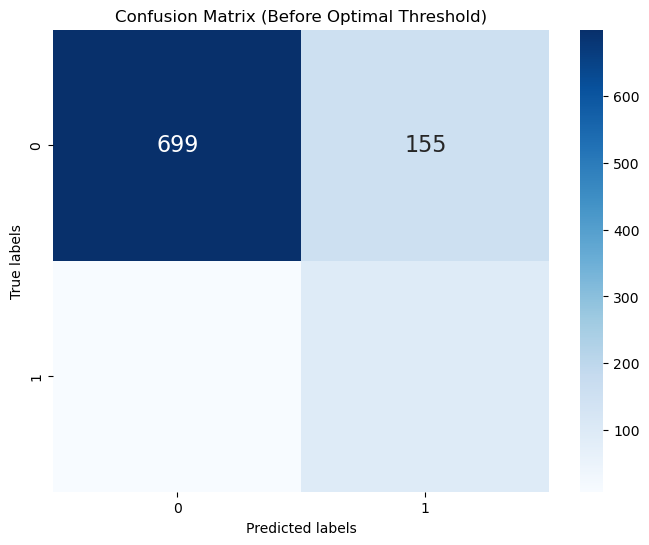

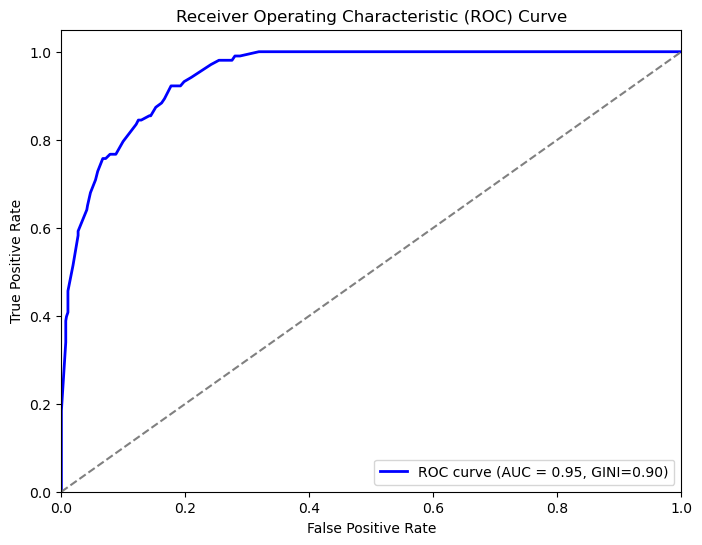

Optimal Threshold: 0.6206896551724138
Precision at Optimal Threshold:  0.3861788617886179
Recall at Optimal Threshold:  0.9223300970873787
F1 Score at Optimal Threshold:  0.5444126074498568
Confusion Matrix (After Optimal Threshold):


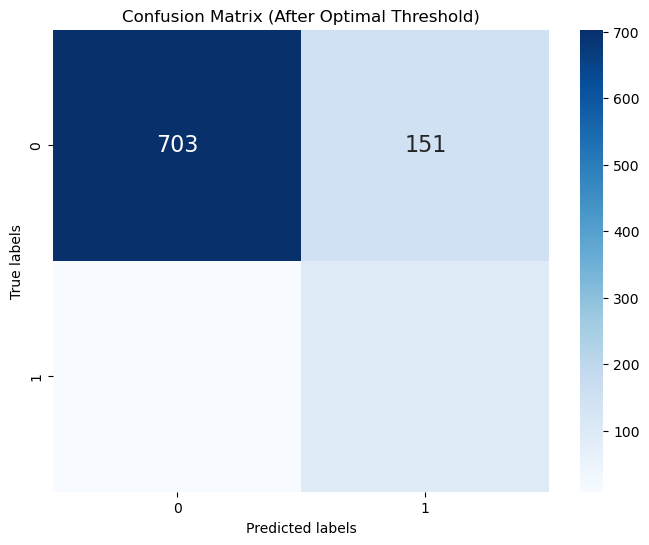

In [26]:
# Define the parameter combinations
max_depth_values = [6, 8, 10]
min_samples_leaf_values = [50, 30, 20]

best_precision = 0
best_params = {}

# Resetting the indices of the oversampled training data
X_train_oversample.reset_index(drop=True, inplace=True)
y_train_oversample.reset_index(drop=True, inplace=True)

# Initialize KFold
kf = KFold(n_splits=5, shuffle=True, random_state=123)

# Iterate over parameter combinations
for max_depth in max_depth_values:
    for min_samples_leaf in min_samples_leaf_values:
        precision_scores = []
        
        # Perform k-fold cross-validation
        for train_index, val_index in kf.split(X_train_oversample, y_train_oversample):
            train_index_list = train_index.tolist()
            val_index_list = val_index.tolist()
            X_train_cv, X_val_cv = X_train_oversample.iloc[train_index_list], X_train_oversample.iloc[val_index_list]
            y_train_cv, y_val_cv = y_train_oversample.iloc[train_index_list], y_train_oversample.iloc[val_index_list]
            
            # Create and train the classifier
            clf = DecisionTreeClassifier(random_state=123, max_depth=max_depth, min_samples_leaf=min_samples_leaf)
            clf.fit(X_train_cv, y_train_cv)
            
            # Make predictions on the validation set
            y_pred = clf.predict(X_val_cv)
            y_prob = clf.predict_proba(X_val_cv)[:, 1]
            
            # Compute precision
            precision = precision_score(y_val_cv, y_pred)
            precision_scores.append(precision)
        
        # Calculate average precision across folds
        avg_precision = np.mean(precision_scores)
        
        # Check if current parameters yield better precision
        if avg_precision > best_precision:
            best_precision = avg_precision
            best_params = {'max_depth': max_depth, 'min_samples_leaf': min_samples_leaf}

# Train the best model on the entire oversampled training data
best_clf = DecisionTreeClassifier(random_state=123, **best_params)
best_clf.fit(X_train_oversample, y_train_oversample)

# Make predictions on the validation set
y_pred = best_clf.predict(X_val)
y_prob = best_clf.predict_proba(X_val)[:, 1]

# Show basic metrics of the best model
show_basic_metrics(y_val, y_pred, y_prob)

With resampled data

Precision:  0.484375
Recall:  0.30097087378640774
F1 Score:  0.3712574850299401
Confusion Matrix (Before Optimal Threshold):


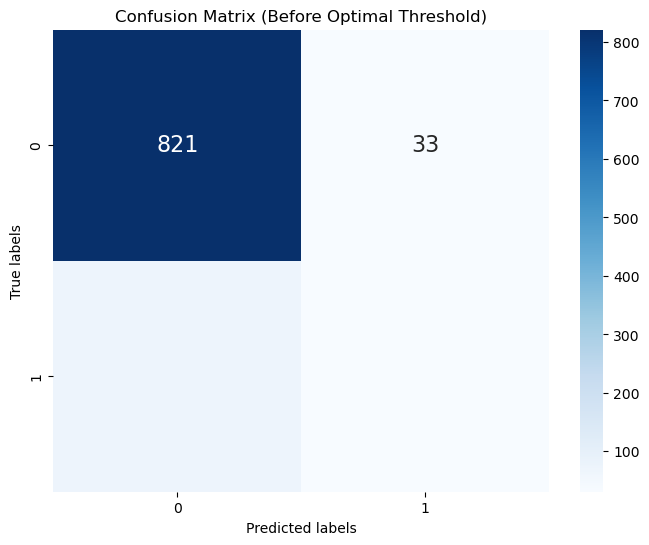

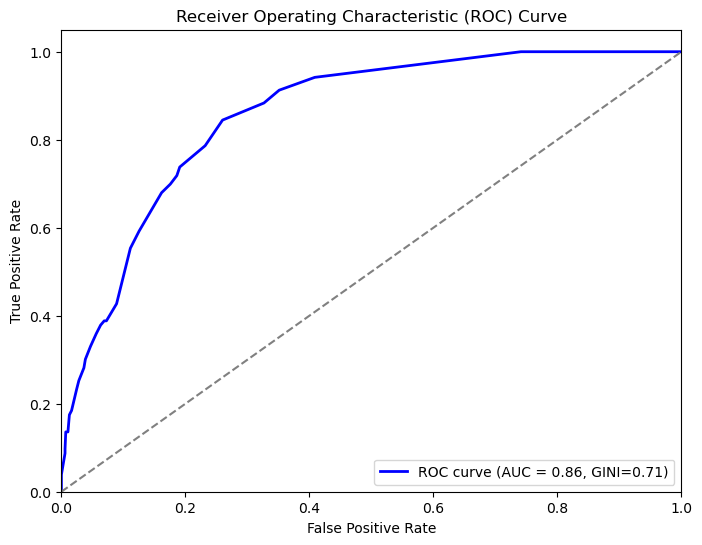

Optimal Threshold: 0.1
Precision at Optimal Threshold:  0.2815533980582524
Recall at Optimal Threshold:  0.8446601941747572
F1 Score at Optimal Threshold:  0.4223300970873786
Confusion Matrix (After Optimal Threshold):


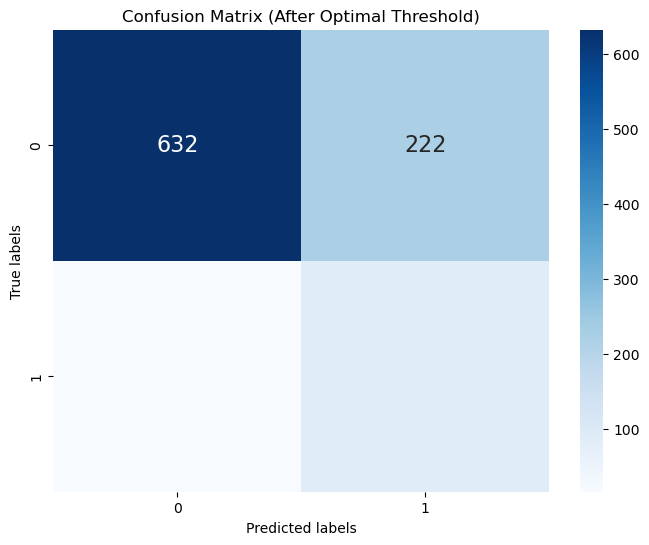

In [27]:
# Define the parameter combinations
max_depth_values = [6, 8, 10]
min_samples_leaf_values = [50, 30, 20]

best_precision = 0
best_params = {}

# Resetting the indices of the oversampled training data
X_train_oversample.reset_index(drop=True, inplace=True)
y_train_oversample.reset_index(drop=True, inplace=True)

# Initialize KFold
kf = KFold(n_splits=5, shuffle=True, random_state=123)

# Iterate over parameter combinations
for max_depth in max_depth_values:
    for min_samples_leaf in min_samples_leaf_values:
        precision_scores = []
        
        # Perform k-fold cross-validation
        for train_index, val_index in kf.split(X_train_resampled, y_train_resampled):
            train_index_list = train_index.tolist()
            val_index_list = val_index.tolist()
            X_train_cv, X_val_cv = X_train_resampled.iloc[train_index_list], X_train_resampled.iloc[val_index_list]
            y_train_cv, y_val_cv = y_train_resampled.iloc[train_index_list], y_train_resampled.iloc[val_index_list]
            
            # Create and train the classifier
            clf = DecisionTreeClassifier(random_state=123, max_depth=max_depth, min_samples_leaf=min_samples_leaf)
            clf.fit(X_train_cv, y_train_cv)
            
            # Make predictions on the validation set
            y_pred = clf.predict(X_val_cv)
            y_prob = clf.predict_proba(X_val_cv)[:, 1]
            
            # Compute precision
            precision = precision_score(y_val_cv, y_pred)
            precision_scores.append(precision)
        
        # Calculate average precision across folds
        avg_precision = np.mean(precision_scores)
        
        # Check if current parameters yield better precision
        if avg_precision > best_precision:
            best_precision = avg_precision
            best_params = {'max_depth': max_depth, 'min_samples_leaf': min_samples_leaf}

# Train the best model on the entire oversampled training data
best_clf = DecisionTreeClassifier(random_state=123, **best_params)
best_clf.fit(X_train_resampled, y_train_resampled)

# Make predictions on the validation set
y_pred = best_clf.predict(X_val)
y_prob = best_clf.predict_proba(X_val)[:, 1]

# Show basic metrics of the best model
show_basic_metrics(y_val, y_pred, y_prob)

### Logistic Regression

With oversampled data

Precision:  0.25227963525835867
Recall:  0.8058252427184466
F1 Score:  0.3842592592592593
Confusion Matrix (Before Optimal Threshold):


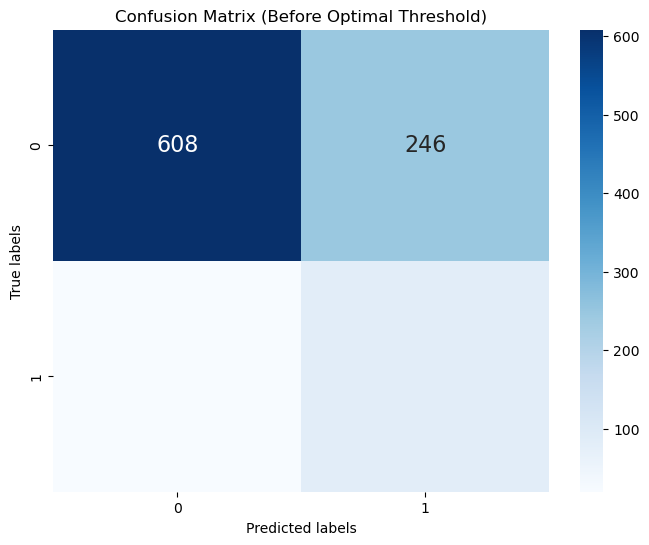

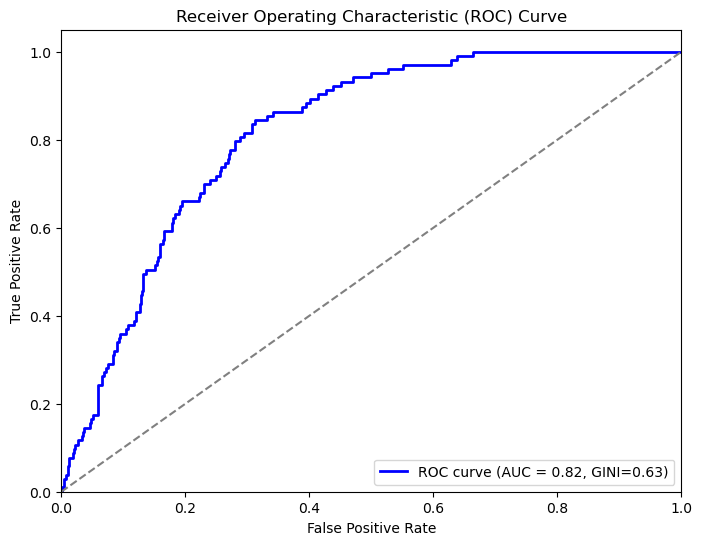

Optimal Threshold: 0.49234366050663386
Precision at Optimal Threshold:  0.2457627118644068
Recall at Optimal Threshold:  0.8446601941747572
F1 Score at Optimal Threshold:  0.38074398249452956
Confusion Matrix (After Optimal Threshold):


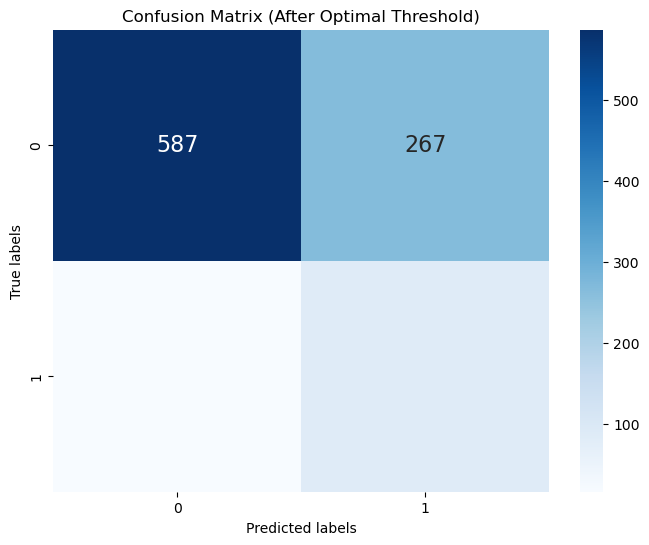

In [28]:
# Define the parameter combinations
alpha_values = [0.001, 0.01, 0.1, 1, 10]  # These are regularization strengths for L1 regularization

best_precision = 0
best_params = {}

# Resetting the indices of the oversampled training data
X_train_oversample.reset_index(drop=True, inplace=True)
y_train_oversample.reset_index(drop=True, inplace=True)

# Initialize KFold
kf = KFold(n_splits=5, shuffle=True, random_state=123)

# Iterate over parameter combinations
for alpha in alpha_values:
    precision_scores = []
    
    # Perform k-fold cross-validation
    for train_index, val_index in kf.split(X_train_oversample, y_train_oversample):
        train_index_list = train_index.tolist()
        val_index_list = val_index.tolist()
        X_train_cv, X_val_cv = X_train_oversample.iloc[train_index_list], X_train_oversample.iloc[val_index_list]
        y_train_cv, y_val_cv = y_train_oversample.iloc[train_index_list], y_train_oversample.iloc[val_index_list]
        
        # Create and train the classifier
        clf = LogisticRegression(random_state=123, penalty='l1', C=alpha, solver='liblinear')
        clf.fit(X_train_cv, y_train_cv)
        
        # Make predictions on the validation set
        y_pred = clf.predict(X_val_cv)
        
        # Compute precision
        precision = precision_score(y_val_cv, y_pred)
        precision_scores.append(precision)
    
    # Calculate average precision across folds
    avg_precision = np.mean(precision_scores)
    
    # Check if current parameters yield better precision
    if avg_precision > best_precision:
        best_precision = avg_precision
        best_params = {'alpha': alpha}

# Train the best model on the entire oversampled training data
best_clf = LogisticRegression(random_state=123, penalty='l1', C=best_params['alpha'], solver='liblinear')
best_clf.fit(X_train_oversample, y_train_oversample)

# Make predictions on the validation set
y_pred = best_clf.predict(X_val)
y_prob = best_clf.predict_proba(X_val)[:, 1]

# Show basic metrics of the best model
show_basic_metrics(y_val, y_pred, y_prob)


With resampled data

Precision:  0.2523364485981308
Recall:  0.2621359223300971
F1 Score:  0.2571428571428571
Confusion Matrix (Before Optimal Threshold):


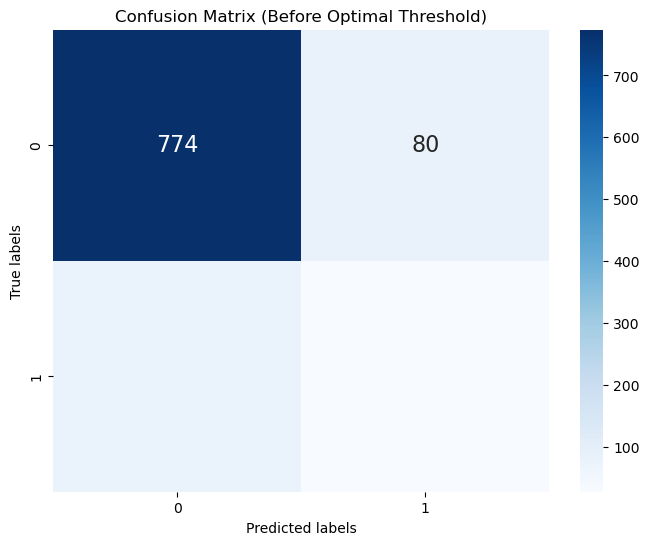

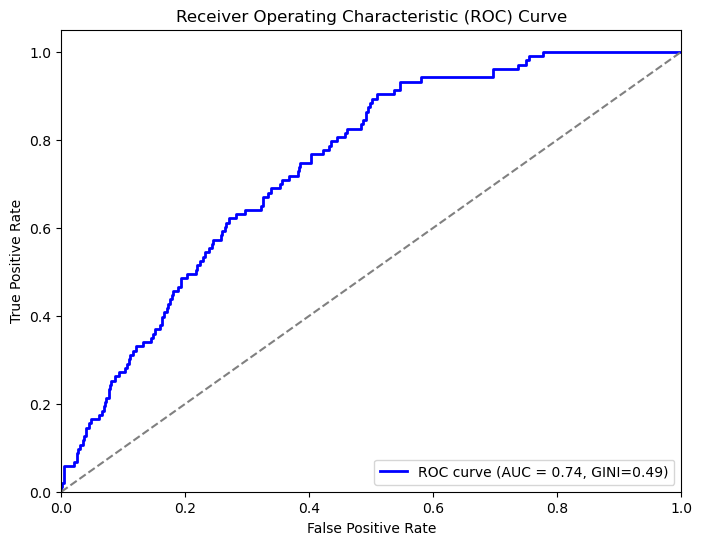

Optimal Threshold: 0.07322235401163663
Precision at Optimal Threshold:  0.17613636363636365
Recall at Optimal Threshold:  0.9029126213592233
F1 Score at Optimal Threshold:  0.29477020602218695
Confusion Matrix (After Optimal Threshold):


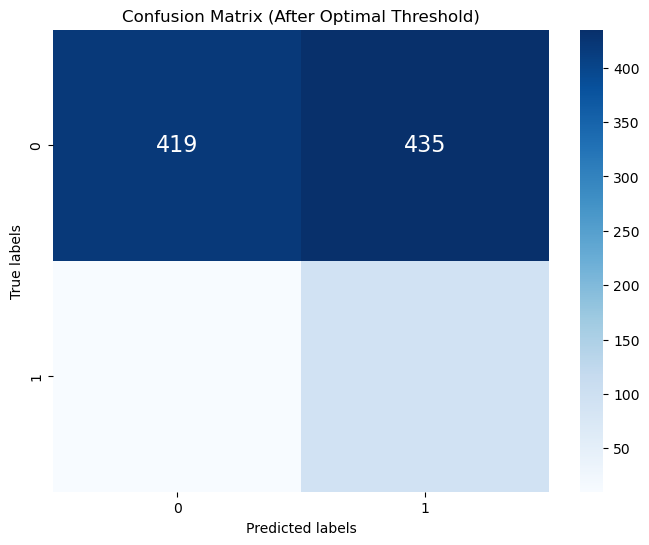

In [29]:
# Define the parameter combinations
alpha_values = [0.001, 0.01, 0.1, 1, 10]  # These are regularization strengths for L1 regularization

best_precision = 0
best_params = {}

# Resetting the indices of the oversampled training data
X_train_resampled.reset_index(drop=True, inplace=True)
y_train_resampled.reset_index(drop=True, inplace=True)

# Initialize KFold
kf = KFold(n_splits=5, shuffle=True, random_state=123)

# Iterate over parameter combinations
for alpha in alpha_values:
    precision_scores = []
    
    # Perform k-fold cross-validation
    for train_index, val_index in kf.split(X_train_resampled, y_train_resampled):
        train_index_list = train_index.tolist()
        val_index_list = val_index.tolist()
        X_train_cv, X_val_cv = X_train_resampled.iloc[train_index_list], X_train_resampled.iloc[val_index_list]
        y_train_cv, y_val_cv = y_train_resampled.iloc[train_index_list], y_train_resampled.iloc[val_index_list]
        
        # Create and train the classifier
        clf = LogisticRegression(random_state=123, penalty='l1', C=alpha, solver='liblinear')
        clf.fit(X_train_cv, y_train_cv)
        
        # Make predictions on the validation set
        y_pred = clf.predict(X_val_cv)
        
        # Compute precision
        precision = precision_score(y_val_cv, y_pred)
        precision_scores.append(precision)
    
    # Calculate average precision across folds
    avg_precision = np.mean(precision_scores)
    
    # Check if current parameters yield better precision
    if avg_precision > best_precision:
        best_precision = avg_precision
        best_params = {'alpha': alpha}

# Train the best model on the entire oversampled training data
best_clf = LogisticRegression(random_state=123, penalty='l1', C=best_params['alpha'], solver='liblinear')
best_clf.fit(X_train_resampled, y_train_resampled)

# Make predictions on the validation set
y_pred = best_clf.predict(X_val)
y_prob = best_clf.predict_proba(X_val)[:, 1]

# Show basic metrics of the best model
show_basic_metrics(y_val, y_pred, y_prob)


### Random Forest

With oversample data

Precision:  0.6623376623376623
Recall:  0.9902912621359223
F1 Score:  0.7937743190661478
Confusion Matrix (Before Optimal Threshold):


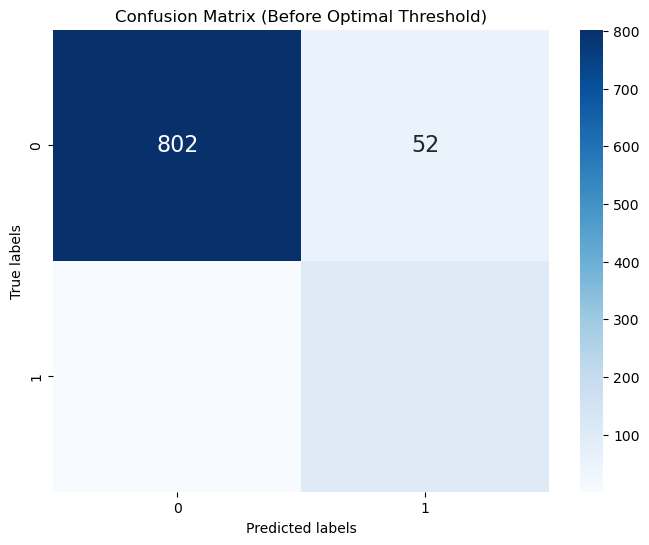

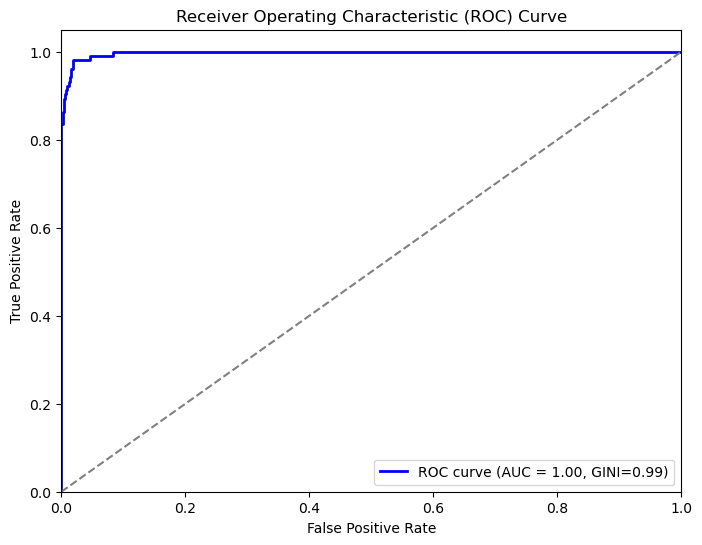

Optimal Threshold: 0.6351987762788063
Precision at Optimal Threshold:  0.8632478632478633
Recall at Optimal Threshold:  0.9805825242718447
F1 Score at Optimal Threshold:  0.9181818181818182
Confusion Matrix (After Optimal Threshold):


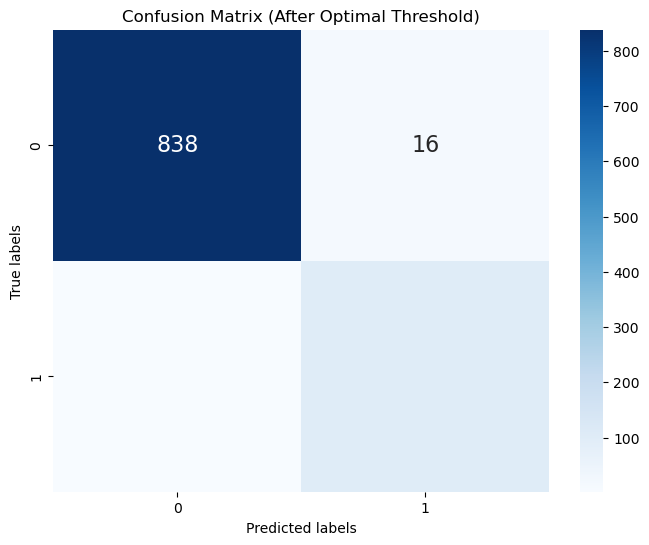

In [30]:
# Define the parameter combinations
n_estimators_values = [10, 50, 100]
max_depth_values = [6, 8, 10, None]
min_samples_leaf_values = [30, 20, 10]

best_precision = 0
best_params = {}

# Resetting the indices of the oversampled training data
X_train_oversample.reset_index(drop=True, inplace=True)
y_train_oversample.reset_index(drop=True, inplace=True)

# Initialize KFold
kf = KFold(n_splits=5, shuffle=True, random_state=123)

# Iterate over parameter combinations
for n_estimators in n_estimators_values:
    for max_depth in max_depth_values:
        for min_samples_leaf in min_samples_leaf_values:
            precision_scores = []
            
            # Perform k-fold cross-validation
            for train_index, val_index in kf.split(X_train_oversample, y_train_oversample):
                train_index_list = train_index.tolist()
                val_index_list = val_index.tolist()
                X_train_cv, X_val_cv = X_train_oversample.iloc[train_index_list], X_train_oversample.iloc[val_index_list]
                y_train_cv, y_val_cv = y_train_oversample.iloc[train_index_list], y_train_oversample.iloc[val_index_list]
                
                # Create and train the classifier
                clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=123)
                clf.fit(X_train_cv, y_train_cv)
                
                # Make predictions on the validation set
                y_pred = clf.predict(X_val_cv)
                
                # Compute precision
                precision = precision_score(y_val_cv, y_pred)
                precision_scores.append(precision)
            
            # Calculate average precision across folds
            avg_precision = np.mean(precision_scores)
            
            # Check if current parameters yield better precision
            if avg_precision > best_precision:
                best_precision = avg_precision
                best_params = {'n_estimators': n_estimators, 'max_depth': max_depth, 'min_samples_leaf': min_samples_leaf}

# Train the best model on the entire oversampled training data
best_clf = RandomForestClassifier(n_estimators=best_params['n_estimators'], max_depth=best_params['max_depth'], min_samples_leaf=best_params['min_samples_leaf'], random_state=123)
best_clf.fit(X_train_oversample, y_train_oversample)

# Make predictions on the validation set
y_pred = best_clf.predict(X_val)
y_prob = best_clf.predict_proba(X_val)[:, 1]

# Show basic metrics of the best model
show_basic_metrics(y_val, y_pred, y_prob)

With resampled data

Precision:  0.6363636363636364
Recall:  0.33980582524271846
F1 Score:  0.44303797468354433
Confusion Matrix (Before Optimal Threshold):


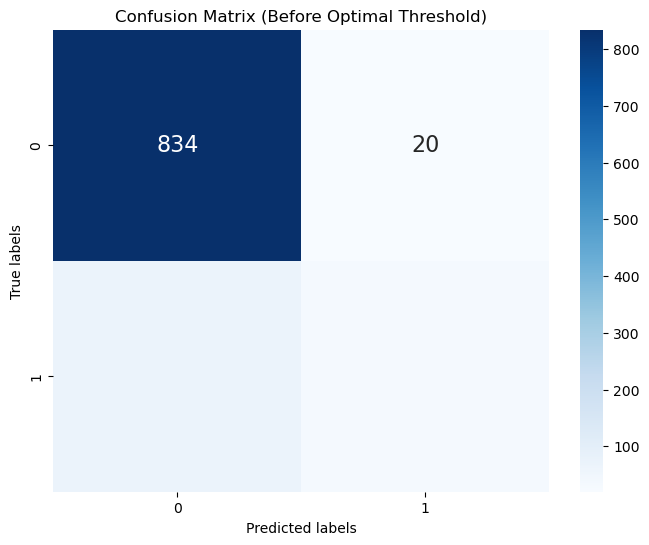

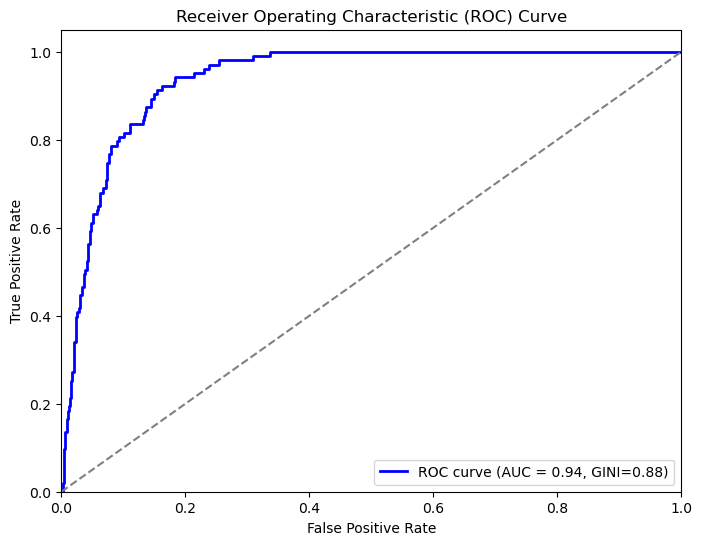

Optimal Threshold: 0.21291909867079375
Precision at Optimal Threshold:  0.40772532188841204
Recall at Optimal Threshold:  0.9223300970873787
F1 Score at Optimal Threshold:  0.5654761904761905
Confusion Matrix (After Optimal Threshold):


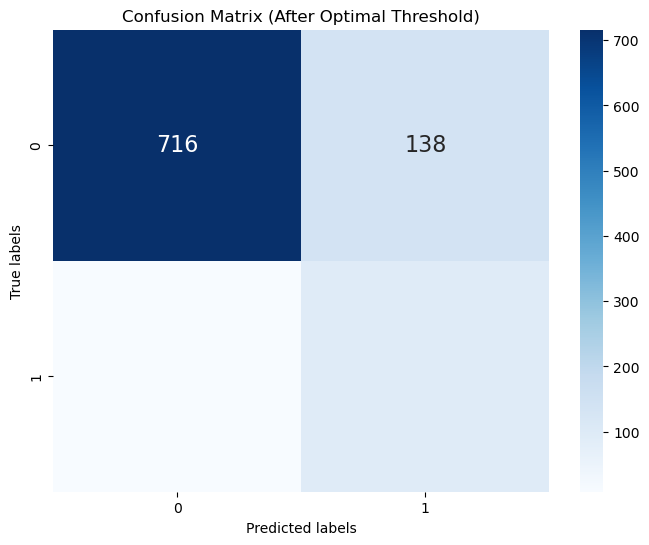

In [31]:
# Define the parameter combinations
n_estimators_values = [10, 50, 100]
max_depth_values = [6, 8, 10, None]
min_samples_leaf_values = [30, 20, 10]

best_precision = 0
best_params = {}

# Resetting the indices of the oversampled training data
X_train_resampled.reset_index(drop=True, inplace=True)
y_train_resampled.reset_index(drop=True, inplace=True)

# Initialize KFold
kf = KFold(n_splits=5, shuffle=True, random_state=123)

# Iterate over parameter combinations
for n_estimators in n_estimators_values:
    for max_depth in max_depth_values:
        for min_samples_leaf in min_samples_leaf_values:
            precision_scores = []
            
            # Perform k-fold cross-validation
            for train_index, val_index in kf.split(X_train_resampled, y_train_resampled):
                train_index_list = train_index.tolist()
                val_index_list = val_index.tolist()
                X_train_cv, X_val_cv = X_train_resampled.iloc[train_index_list], X_train_resampled.iloc[val_index_list]
                y_train_cv, y_val_cv = y_train_resampled.iloc[train_index_list], y_train_resampled.iloc[val_index_list]
                
                # Create and train the classifier
                clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=123)
                clf.fit(X_train_cv, y_train_cv)
                
                # Make predictions on the validation set
                y_pred = clf.predict(X_val_cv)
                
                # Compute precision
                precision = precision_score(y_val_cv, y_pred)
                precision_scores.append(precision)
            
            # Calculate average precision across folds
            avg_precision = np.mean(precision_scores)
            
            # Check if current parameters yield better precision
            if avg_precision > best_precision:
                best_precision = avg_precision
                best_params = {'n_estimators': n_estimators, 'max_depth': max_depth, 'min_samples_leaf': min_samples_leaf}

# Train the best model on the entire oversampled training data
best_clf = RandomForestClassifier(n_estimators=best_params['n_estimators'], max_depth=best_params['max_depth'], min_samples_leaf=best_params['min_samples_leaf'], random_state=123)
best_clf.fit(X_train_resampled, y_train_resampled)

# Make predictions on the validation set
y_pred = best_clf.predict(X_val)
y_prob = best_clf.predict_proba(X_val)[:, 1]

# Show basic metrics of the best model
show_basic_metrics(y_val, y_pred, y_prob)